In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

## Import

In [2]:
#export
from exp.nb_02 import *

In [3]:
#export
import torch.nn.functional as F

## Let's setup our data

In [4]:
mpl.rcParams['image.cmap'] = 'gray'

In [5]:
#get_data() defined in earlier notebooks -> .py
x_train,y_train,x_valid,y_valid = get_data()

In [6]:
x_train.shape

torch.Size([50000, 784])

In [7]:
n,p = x_train.shape # num images,num pixel values
c = (y_train.max() + 1).item() #num classes
nh = 50 #num hidden layers (arbitrary-ish)
n,p,c #print them

(50000, 784, 10)

# Let's setup our model
## (using pytorch nn.Module)

In [8]:
#nn.Module was imported in earlier notebook
class Model(nn.Module): 
    def __init__(self,n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh),nn.ReLU(),nn.Linear(nh,n_out)]
        
    def __call__(self,x):
        for l in self.layers: x = l(x)
        return x   

In [9]:
model = Model(p,nh,c)

In [10]:
pred = model(x_train)

# Let's define a loss function

In [11]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

## -->Exploration of how log_softmax() works and cross-entropy loss

In [12]:
x = torch.randn(5);
x

tensor([ 0.7497, -1.1975, -1.1989,  0.2238,  1.2403])

In [13]:
a = x[0].exp()
a

tensor(2.1165)

In [14]:
b = x.exp()
b

tensor([2.1165, 0.3020, 0.3015, 1.2508, 3.4567])

In [15]:
c1 = b.sum(0) #don't keep dim over which you summed
c1

tensor(7.4274)

In [16]:
c2 = b.sum(0,keepdim=True) #keep dim over which you summed
c2

tensor([7.4274])

In [17]:
b/c1 #returns the same as b/c2

tensor([0.2850, 0.0407, 0.0406, 0.1684, 0.4654])

In [18]:
b/c2 #returns the samne as b/c1

tensor([0.2850, 0.0407, 0.0406, 0.1684, 0.4654])

In [19]:
sm_preds = log_softmax(pred) #log_softmax predictions
sm_preds[:3] #loss landscape for first 3 images

tensor([[-2.1716, -2.2389, -2.1218, -2.2766, -2.3863, -2.3663, -2.5781, -2.6097,
         -2.1043, -2.3049],
        [-2.1986, -2.3499, -2.1167, -2.2967, -2.3920, -2.3900, -2.3855, -2.4639,
         -2.0853, -2.4287],
        [-2.2968, -2.3643, -2.0965, -2.2235, -2.3792, -2.3731, -2.3098, -2.4128,
         -2.1855, -2.4395]], grad_fn=<SliceBackward>)

In [20]:
y_train[:3] # actual label of first image

tensor([5, 0, 4])

In [21]:
-sm_preds[[0,1,2],y_train[:3]] #loss on correctly predicting first 3 images

tensor([2.3663, 2.1986, 2.3792], grad_fn=<NegBackward>)

## --> End of Exploration

In [22]:
#me trying to come up with my own nnl() function:
def nll(ll,target): return -(ll[range(target.shape[0]),target]).mean()

In [23]:
loss = nll(sm_preds,y_train)
loss

tensor(2.3065, grad_fn=<NegBackward>)

In [24]:
# simplify log_softmax()
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

In [25]:
test_near(nll(log_softmax(pred),y_train),loss)

In [26]:
#simplification to avoid calculating large numbers 
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

In [27]:
#compare our logsumexp() func to PyTorch .logsumexp()
test_near(logsumexp(pred), pred.logsumexp(-1))

In [28]:
#use PyTorch version of logsumexp() in our softmax func
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [29]:
#test our new log_softmax()
test_near(nll(log_softmax(pred),y_train),loss)

In [30]:
#Pytorch implements F.log_softmax and F.nll_loss
test_near(F.nll_loss(F.log_softmax(pred,dim=-1),y_train),loss)

In [31]:
#PyTorch combines F.log_softmax() and F.nll_loss into F.cross_entropy()
test_near(F.cross_entropy(pred,y_train),loss)

## Okay now we have a loss function called F.cross_entropy(predictions,y_train)
### We can now try to train our model

In [32]:
#apparently cross_entropy is class that is callable??
loss_func = F.cross_entropy

## --> Exploration of argmax() amongst other things..

In [33]:
bleep = torch.randn(3)
bleep

tensor([-0.4919, -0.4614,  0.2526])

In [34]:
indMax = bleep.argmax(dim=0); #find index of max value
bleep[indMax.item()]#check to make sure it returns the max value

tensor(0.2526)

In [35]:
blop = torch.tensor([0,1,0])

## --> End of Exploration

In [36]:
#Initial accuracy is slightly better than random
#We expect this since we haven't trained yet
acc =((pred.argmax(dim=1)== y_train).float().sum())/pred.shape[0]

In [37]:
#export
#define a function to calculate accuracy of preds
def accuracy(out,yb): return (out.argmax(dim=1)==yb).float().mean()

In [38]:
test_near(accuracy(pred,y_train),acc)

## Let's get to splitting data into mini-batches 

In [39]:
bs = 64 #batch size has to be a power of 2 or something??

In [40]:
x_train.shape

torch.Size([50000, 784])

In [41]:
xb = x_train[:bs]
xb.shape[0] == bs;

yb = y_train[:bs]
yb.shape[0] == bs

True

In [42]:
#preds for a mini-batch
pred = model(xb)
pred.shape

torch.Size([64, 10])

In [43]:
#Find our loss on this mini-batch
loss_func(pred,yb)

tensor(2.3169, grad_fn=<NllLossBackward>)

In [44]:
#accuracy for mini-batch
accuracy(pred,yb)

tensor(0.1250)

In [45]:
#define a learning rate and iterations/input
lr = 0.50
epochs = 1

In [46]:
#try a training loop:

#forward pass
for i in range(epochs):
    for k in range(n // bs): #NOT SURE WHY HE HAS SOMETHING DIFFERENT
        start_k = k * bs
        end_k = start_k + bs
        xb = x_train[start_k:end_k]
        yb = y_train[start_k:end_k]
        loss = loss_func(model(xb),yb)
        
#backward pass
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l,'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()

In [47]:
#I actually achieve 100% accuracy...
#but this is on training data!
loss_func(model(xb),yb),accuracy(model(xb),yb)

(tensor(0.0381, grad_fn=<NllLossBackward>), tensor(1.))

## Using parameters and optim

## Original Model:

In [48]:
#nn.Module was imported in earlier notebook
class Model(nn.Module): 
    def __init__(self,n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh),nn.ReLU(),nn.Linear(nh,n_out)]
        
    def __call__(self,x):
        for l in self.layers: x = l(x)
        return x 

## Parameters

 ## Updated Model:

In [49]:
#I guess we want to rearrange how our model works??
#Not sure why yet.
class Model(nn.Module):
    def __init__(self,n_in,nh,n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))

In [50]:
model = Model(p,nh,c)

In [51]:
for name,l in model.named_children():print(f"Name of child: {name} -->Layer: {l}")

Name of child: l1 -->Layer: Linear(in_features=784, out_features=50, bias=True)
Name of child: l2 -->Layer: Linear(in_features=50, out_features=10, bias=True)


In [52]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [53]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

## -->Okay, rewind to understand __setattr__()

In [54]:
class DummyModule():
    def __init__(self,n_in,nh,n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __setattr__(self,k,v):
        if not k.startswith('_'): self._modules[k] = v
        super().__setattr__(k,v)#need to understand this
        
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [55]:
mdl = DummyModule(p,nh,c)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [56]:
#remember, parameters() is a generator so it doesn't
#return a list but rather an iterable thing-like
mdl.parameters()

<generator object DummyModule.parameters at 0x1a28552840>

In [57]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

## --> End of Exploration

### Back to the updated model...

In [58]:
class Model(nn.Module):
    def __init__(self,n_in,nh,n_out):
        super().__init__() #this does equiv of DummyModule()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))

## Update fit w/ parameter refactoring:

In [59]:
def fit():
    for i in range(epochs):
        for k in range(n // bs): #NOT SURE WHY HE HAS SOMETHING DIFFERENT
            start_k = k * bs
            end_k = start_k + bs
            xb = x_train[start_k:end_k]
            yb = y_train[start_k:end_k]
            loss = loss_func(model(xb),yb)

    #backward pass
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()
    #             for l in model.layers:
    #                 if hasattr(l,'weight'):
    #                     l.weight -= l.weight.grad * lr
    #                     l.bias   -= l.bias.grad * lr
    #                     l.weight.grad.zero_()
    #                     l.bias.grad.zero_()

In [60]:
model = Model(p,nh,c)

In [61]:
fit()

In [62]:
loss_func(model(xb),yb),accuracy(model(xb),yb)

(tensor(0.0392, grad_fn=<NllLossBackward>), tensor(1.))

## Registering Modules

Okay let's just go back to a layer list instead of listing out each layer individually

In [63]:
layers = [nn.Linear(p,nh), nn.ReLU(), nn.Linear(nh,c)]

In [64]:
class Model(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)                                                           
    def __call__(self,x):
        for l in self.layers: x = l(x)
        return x                                                          

In [65]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

## nn.ModuleList

### Okay so instead of enumerating, pyTorch has an nn.Sequential

In [66]:
class SequentialModel(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self,x):
        for l in self.layers: x = l(x)
        return x

In [67]:
#where exactly in ModuleList, the module_list is initialized
#is still quite fuzzy...need to revisit
nn.ModuleList??

In [68]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [69]:
loss_func(model(xb),yb),accuracy(model(xb),yb)

(tensor(2.3124, grad_fn=<NllLossBackward>), tensor(0.0469))

In [70]:
fit()
loss_func(model(xb),yb),accuracy(model(xb),yb)

(tensor(0.0421, grad_fn=<NllLossBackward>), tensor(1.))

## nn.Sequential does the same thing as Sequential model

In [71]:
model = nn.Sequential(nn.Linear(p,nh),nn.ReLU(),nn.Linear(nh,c))

In [72]:
fit()
loss_func(model(xb),yb),accuracy(model(xb),yb)

(tensor(0.0449, grad_fn=<NllLossBackward>), tensor(1.))

In [73]:
nn.Sequential??

## optim

Let's replace our previous manually coded optimization step:

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

and instead use just:

```python
opt.step()
opt.zero_grad()
```

In [74]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params,self.lr=list(params),lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [75]:
model = nn.Sequential(nn.Linear(p,nh),nn.ReLU(),nn.Linear(nh,c))

In [76]:
opt = Optimizer(model.parameters())

## Update fit with optim refactoring

In [77]:
def fit():
    for i in range(epochs):
        for k in range(n // bs): #NOT SURE WHY HE HAS SOMETHING DIFFERENT
            start_k = k * bs
            end_k = start_k + bs
            xb = x_train[start_k:end_k]
            yb = y_train[start_k:end_k]
            loss = loss_func(model(xb),yb)

    #backward pass
            loss.backward()
            opt.step()
            opt.zero_grad()
#             with torch.no_grad():
#                 for p in model.parameters(): p -= p.grad * lr
#                 model.zero_grad()
   

In [78]:
fit()
loss_func(model(xb),yb),accuracy(model(xb),yb)

(tensor(0.0463, grad_fn=<NllLossBackward>), tensor(1.))

PyTorch already provides this exact functionality in `optim.SGD` (it also handles stuff like momentum, which we'll look at later - except we'll be doing it in a more flexible way!)

### Let's import that from pytorch

In [79]:
#export
from torch import optim

### Okay let's take our two things from before....model and opt

In [80]:
model = nn.Sequential(nn.Linear(p,nh),nn.ReLU(),nn.Linear(nh,c))

### Use optim.SGD...takes params and lr from documentation

In [81]:
opt = optim.SGD(model.parameters(),lr) #Optimizer(model.parameters())

### take our updated fit function...

In [82]:
def fit():
    for i in range(epochs):
        for k in range(n // bs): #NOT SURE WHY HE HAS SOMETHING DIFFERENT
            start_k = k * bs
            end_k = start_k + bs
            xb = x_train[start_k:end_k]
            yb = y_train[start_k:end_k]
            loss = loss_func(model(xb),yb)

    #backward pass
            loss.backward()
            opt.step()
            opt.zero_grad()

In [83]:
fit()
loss_func(model(xb),yb),accuracy(model(xb),yb)

(tensor(0.0465, grad_fn=<NllLossBackward>), tensor(1.))

### It worked! cool...

### For Jeremy's sake, we will combine model, opt into a get_model() function

In [84]:
def get_model():
    model = nn.Sequential(nn.Linear(p,nh),nn.ReLU(),nn.Linear(nh,c))
    return model, optim.SGD(model.parameters(),lr)

In [85]:
model,opt = get_model()
loss_func(model(xb),yb),accuracy(model(xb),yb)

(tensor(2.3242, grad_fn=<NllLossBackward>), tensor(0.1406))

In [86]:
fit()
loss,acc = loss_func(model(xb),yb),accuracy(model(xb),yb)

### This also worked!!

Use a randomized test...

In [87]:
assert acc > 0.7

Passed!

## Dataset and Dataloader!!! ... really hoping to understand this better

It's clunky to iterate through minibatches of x and y values
separately:

```python
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
```

Instead, let's do these two steps together, by introducting a `Dataset` classs:

```python
    xb,yb = train_ds[i*bs : i*bs+bs]
```

In [88]:
#export
class Dataset():
    def __init__(self,x,y): self.x, self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self,i): return self.x[i], self.y[i]

In [89]:
#create datasets and make sure they have the same length as raw data
train_ds, valid_ds = Dataset(x_train,y_train),Dataset(x_valid,y_valid)
assert len(train_ds) == len(y_train)
assert len(valid_ds) == len(y_valid)

In [90]:
#try to grab a batch using Dataset() class
xb, yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

### take our updated fit() function and refactor with Dataset() class

In [91]:
def fit():
    for i in range(epochs):
        for k in range(n // bs): #NOT SURE WHY HE HAS SOMETHING DIFFERENT
            xb,yb = train_ds[k*bs:k*bs + bs]
#             start_k = k * bs
#             end_k = start_k + bs
#             xb = x_train[start_k:end_k]
#             yb = y_train[start_k:end_k]
            loss = loss_func(model(xb),yb)

    #backward pass
            loss.backward()
            opt.step()
            opt.zero_grad()

In [92]:
model,opt = get_model()

In [93]:
fit()
loss,acc = loss_func(model(xb),yb),accuracy(model(xb),yb)

In [94]:
assert acc>0.7

In [95]:
loss,acc

(tensor(0.0180, grad_fn=<NllLossBackward>), tensor(1.))

## Dataloader

Previously, our loop iterated over batches (xb,yb)
like this:

```python
    for i in range((n-1)//bs + 1):
        xb,yb = train_ds[i*bs:i*bs+bs]
```

Let's make our loop much cleaner, using a data loader:

```python
    for xb,yb in train_dl:
```

In [96]:
class DataLoader():
    def __init__(self, ds, bs): self.ds, self.bs = ds,bs
    def __iter__(self):
        for i in range(0,len(self.ds),bs): yield self.ds[i:i+self.bs]

In [97]:
train_dl = DataLoader(train_ds,bs)
valid_dl = DataLoader(valid_ds,bs)

In [98]:
xb,yb = next(iter(train_dl));
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
         1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
         9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0]))

In [99]:
xb.shape, yb.shape

(torch.Size([64, 784]), torch.Size([64]))

tensor(5)

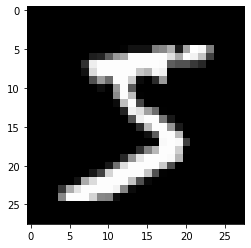

In [100]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [101]:
model,opt = get_model()

### take our updated fit() function and refactor with DataLoader() class...

In [102]:
def fit():
    for i in range(epochs):
        for xb,yb in train_dl:
#         for k in range(n // bs): #NOT SURE WHY HE HAS SOMETHING DIFFERENT
#             xb,yb = train_ds[k*bs:k*bs + bs]
            loss = loss_func(model(xb),yb)

    #backward pass
            loss.backward()
            opt.step()
            opt.zero_grad()

In [103]:
fit()
loss,acc = loss_func(model(xb),yb),accuracy(model(xb),yb)

In [104]:
assert acc > 0.7

In [105]:
loss,acc

(tensor(0.1751, grad_fn=<NllLossBackward>), tensor(0.9375))

Okay let's cleanup our fit() function a bit

In [106]:
def fit():
    for i in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred,yb)
    #backward pass
            loss.backward()
            opt.step()
            opt.zero_grad()

## Random Sampling

We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

## -->Exploration of torch.randperm()

In [107]:
#shuffling my indices (inputs)
idxs =torch.randperm(20)
idxs

tensor([ 7,  0, 17, 16, 18,  3, 13,  8,  6,  4,  1,  9,  2, 14,  5, 10, 15, 19,
        12, 11])

In [108]:
#producing each batch in consecutive order of the shuffled indices
for i in range(0,20,4): print(idxs[i:i+4])

tensor([ 7,  0, 17, 16])
tensor([18,  3, 13,  8])
tensor([6, 4, 1, 9])
tensor([ 2, 14,  5, 10])
tensor([15, 19, 12, 11])


## -->End of exporation

In [109]:
#create a Sampler class that returns the indices
#of the inputs that you want to grab from dataset
class Sampler():
    def __init__(self,ds,bs,shuffle=False):
        self.n = len(ds)
        self.bs = bs
        self.shuffle = shuffle
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n)if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [110]:
#make a smaller dataset
#you have to use *train_ds so python knows
#there are more than one argument contained
small_ds = Dataset(*train_ds[:10])
len(small_ds)

10

In [111]:
s = Sampler(small_ds, 3, False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [112]:
#different from last time
s = Sampler(small_ds, 3, False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [113]:
#different from last times
s = Sampler(small_ds, 3, False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [114]:
len(small_ds)

10

## Exploration of zip and torch.stack and other stuff

In [115]:
hello = torch.randn(3)
there = torch.randn(3)

In [116]:
hello

tensor([-0.3201, -0.7348,  1.2825])

In [117]:
there

tensor([-0.7150, -1.0039, -0.6368])

In [118]:
bob = zip(hello,there)
bob = [k for k in bob]
bob

[(tensor(-0.3201), tensor(-0.7150)),
 (tensor(-0.7348), tensor(-1.0039)),
 (tensor(1.2825), tensor(-0.6368))]

In [119]:
hello,there = zip(*bob)

In [120]:
hello

(tensor(-0.3201), tensor(-0.7348), tensor(1.2825))

In [121]:
there

(tensor(-0.7150), tensor(-1.0039), tensor(-0.6368))

In [122]:
jim = next(iter(s))
jim

tensor([0, 1, 2])

In [123]:
karen = [small_ds[ii] for ii in jim]
karen

[(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000

In [124]:
janice = small_ds[jim];
cc,dd =janice

In [125]:
aa,bb = zip(*karen)

In [126]:
torch.stack(aa)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [127]:
#let's check to see that I don't need collate()
#by comparing my solution: ds[Sampler(i)]
#versus: collate([ds[i] for i in Sampler(i)])
torch.all(torch.eq(torch.stack(aa),cc))

tensor(True)

## Hey! I found an easier way to implement random sampler!

## -->End of Exploration

Okay let's try to re-do our DataLoader() class using random Sampling()

In [128]:
class DataLoader():
    def __init__(self, ds, sampler): self.ds, self.sampler = ds,sampler
    def __iter__(self):
        for ss in self.sampler: yield self.ds[ss]

In [129]:
train_samp = Sampler(train_ds,bs,shuffle=True)
valid_samp = Sampler(valid_ds,bs,shuffle=False)

In [130]:
train_dl = DataLoader(train_ds,train_samp)
valid_dl = DataLoader(valid_ds,valid_samp)

tensor(3)

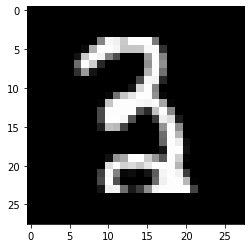

In [131]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(8)

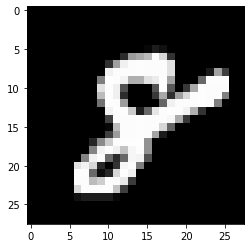

In [132]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(2)

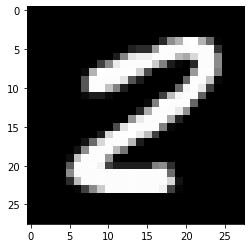

In [133]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

Hey I got different results for each xb[0]! coolio.

In [134]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb),yb),accuracy(model(xb),yb)
assert acc>0.7
loss,acc

(tensor(0.1149, grad_fn=<NllLossBackward>), tensor(0.9375))

Looks good!

## PyTorch DataLoader

In [135]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [136]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

In [137]:
train_dl = DataLoader(train_ds,bs,sampler=RandomSampler(train_ds),collate_fn=collate)
valid_dl = DataLoader(valid_ds,bs,sampler=SequentialSampler(valid_ds),collate_fn=collate)

In [138]:
model,opt = get_model()
fit()
loss_func(model(xb),yb),accuracy(model(xb),yb)

(tensor(0.1337, grad_fn=<NllLossBackward>), tensor(0.9531))

In [139]:
train_dl = DataLoader(train_ds,bs,shuffle=True)
valid_dl = DataLoader(valid_ds,bs,shuffle=False)

In [140]:
model,opt = get_model()
fit()
loss_func(model(xb),yb),accuracy(model(xb),yb)

(tensor(0.0840, grad_fn=<NllLossBackward>), tensor(0.9531))

## Validation

Okay so now we want to have a validation run through without optimization...

### Here is our most up-to-date fit() function:

In [141]:
def fit():
    for i in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred,yb)
    #backward pass
            loss.backward()
            opt.step()
            opt.zero_grad()

Let's make our fit function take in arguments for all the stuff it needs so it isn't dependent on things that are set in the notebook.

In [142]:
def fit(epochs, train_dl, valid_dl, model, loss_func, aopt):
    for i in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred,yb)
    #backward pass
            loss.backward()
            opt.step()
            opt.zero_grad()

Okay next we are going to try to figure out what our validation dataset should be doing

To be honest, I think it is a bit weird to calculate loss on the validation set AS I am training vs AFTER I  am training...I mean I guess it is a way to stop our learning if the model is overfitting...

In [143]:
def fit(epochs, train_dl, valid_dl, model, loss_func, opt, accuracy):
    for i in range(epochs): #number of iterations of training and validation metrics calculated        
        #training forward pass
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred,yb)
        #backward pass
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        #validation forward pass   
        with torch.no_grad():
            total_loss, total_acc = 0.,0.
            for xb,yb in valid_dl:
                pred = model(xb)
                total_loss += loss_func(pred,yb)
                total_acc  += accuracy(pred,yb)
            nb = len(valid_dl) #number of equally-sized mini-batches
            print(f"epoch: {i} | valid_loss: {total_loss / nb} | valid_acc: {total_acc / nb}")
    return total_loss/nb, total_acc/nb        

Jeremy wants to be fancy and make a function to take in train_ds, valid_ds and pop our dataloaders out

In [144]:
#export
def get_dls(train_ds, valid_ds, bs,**kwargs):
    return DataLoader(train_ds, batch_size=bs,shuffle=True,**kwargs), DataLoader(valid_ds, batch_size=2*bs,shuffle=False,**kwargs)   

In [145]:
train_dl,valid_dl = get_dls(train_ds,valid_ds,bs)
model,opt = get_model()
loss,acc = fit(5,train_dl,valid_dl,model,loss_func,opt,accuracy)
loss,acc

epoch: 0 | valid_loss: 0.288716584444046 | valid_acc: 0.9099090099334717
epoch: 1 | valid_loss: 0.27747538685798645 | valid_acc: 0.9209849834442139
epoch: 2 | valid_loss: 0.11218695342540741 | valid_acc: 0.9671677350997925
epoch: 3 | valid_loss: 0.2457146942615509 | valid_acc: 0.9271162748336792
epoch: 4 | valid_loss: 0.11574181169271469 | valid_acc: 0.9660798907279968


(tensor(0.1157), tensor(0.9661))

In [146]:
assert acc>0.9

## Hey I did it!!! I made a model, fit it, and confirmed it using validation data!! Whoohooo.....

# Export

In [147]:
!python notebook2script.py 03_minibatch_training_OMO.ipynb

Converted 03_minibatch_training_OMO.ipynb to exp/nb_03.py
